## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

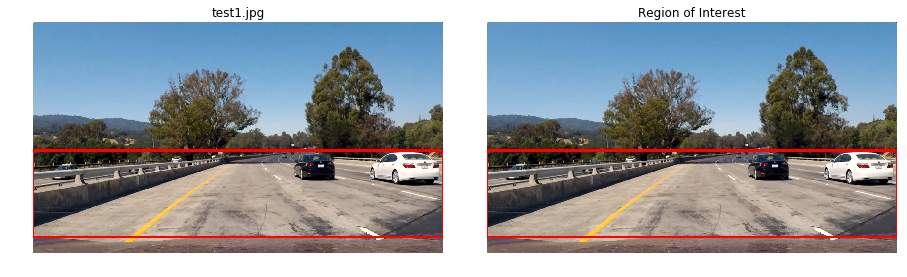

In [1]:
#importing some useful packages
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

IMAGE_SHAPE = (720,1280,3)

TEST_IMAGES_DIR = "test_images/"

Y_BEGIN = 400
Y_END = 670

for filename in os.listdir(TEST_IMAGES_DIR):
    image = mpimg.imread(TEST_IMAGES_DIR + filename)
        
    roi = cv2.rectangle(image, (0, Y_BEGIN), (IMAGE_SHAPE[1], Y_END), (255, 0, 0), 6)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,16))
    fig.tight_layout()
    ax[0].imshow(image)
    ax[0].set_title(filename)
    ax[0].set_axis_off()
    ax[1].imshow(roi)
    ax[1].set_title('Region of Interest')
    ax[1].set_axis_off()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    plt.show()
    break # Comment this line to view the region of interest for all test images

## Feature Extraction
---

In [2]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(image, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0):    
        
        features = []
        # apply color conversion if other than 'RGB'
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else:
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if (spatial_size[0] > 0 and spatial_size[1] > 0):
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            features.append(spatial_features)
        if(hist_bins > 0):
            hist_features = color_hist(feature_image, nbins=hist_bins)
            features.append(hist_features)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
        return np.concatenate(features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_from_files(imgfiles, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                                pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgfiles:
        file_features = []
        # Read in each one by one
        img = cv2.imread(file)
        file_features = extract_features(img, color_space, spatial_size, hist_bins, orient, 
                                         pix_per_cell, cell_per_block, hog_channel)
        
        features.append(file_features)
    # Return list of feature vectors
    return features

## HOG Visualization
---

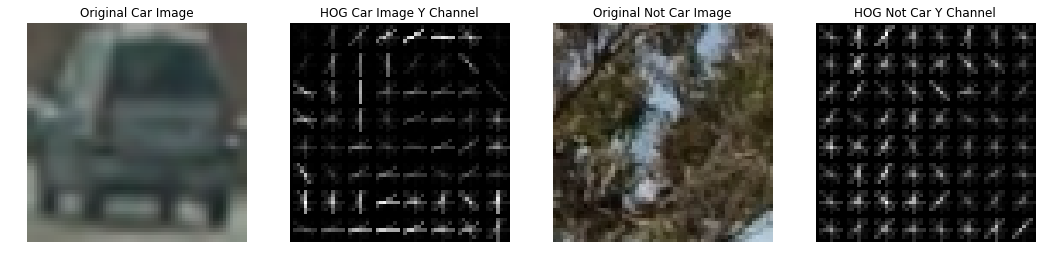

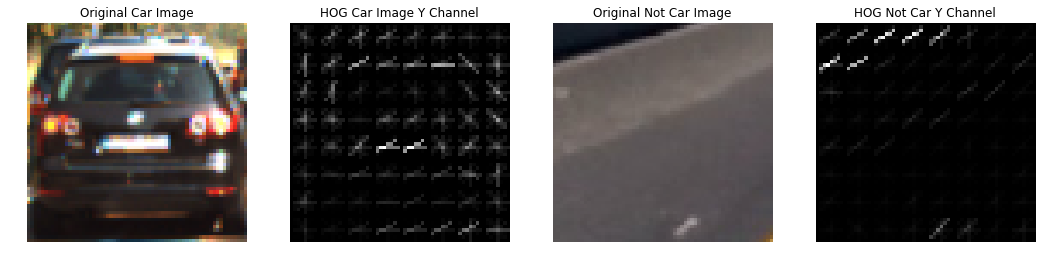

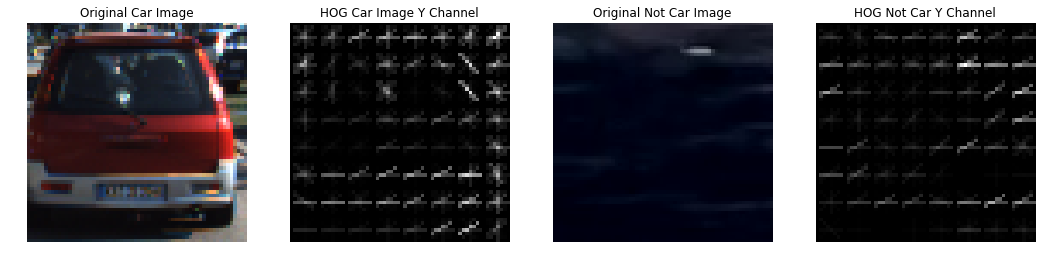

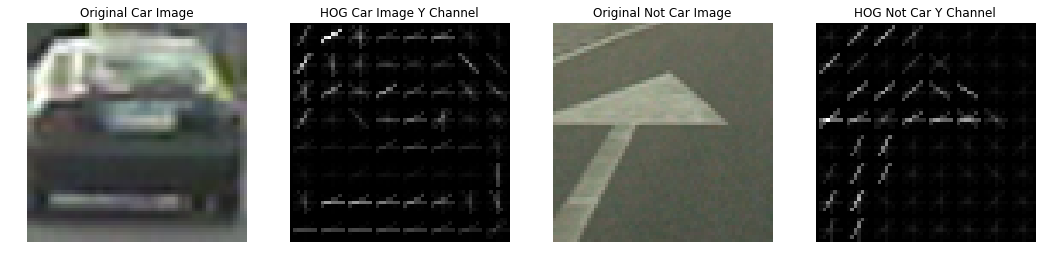

In [3]:
import glob

car_files = glob.glob("./vehicles/*/*.png")
notcar_files = glob.glob("./non-vehicles/*/*.png")

for i in range(4):
    carimg = cv2.cvtColor(cv2.imread(np.random.choice(car_files)), cv2.COLOR_BGR2RGB)
    notcarimg = cv2.cvtColor(cv2.imread(np.random.choice(notcar_files)), cv2.COLOR_BGR2RGB)

    carimg_cs = cv2.cvtColor(carimg, cv2.COLOR_RGB2YCrCb)
    notcarimg_cs = cv2.cvtColor(notcarimg, cv2.COLOR_RGB2YCrCb)

    carhogfeat,carhogimg = get_hog_features(carimg_cs[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    carhogfeat,notcarhogimg = get_hog_features(notcarimg_cs[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

    fig, ax = plt.subplots(1, 4, figsize=(14,5))
    fig.tight_layout()
    ax[0].imshow(carimg)
    ax[0].set_title("Original Car Image")
    ax[0].set_axis_off()
    ax[1].imshow(carhogimg, cmap='gray')
    ax[1].set_title('HOG Car Image Y Channel')
    ax[1].set_axis_off()
    ax[2].imshow(notcarimg)
    ax[2].set_title('Original Not Car Image')
    ax[2].set_axis_off()
    ax[3].imshow(notcarhogimg, cmap='gray')
    ax[3].set_title('HOG Not Car Y Channel')
    ax[3].set_axis_off()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    plt.show()
                

## SVM Training Step
---

In [4]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

print("Preparing data {} vehicle samples {} non-vehicle samples ...".format(len(car_files), len(notcar_files)))
start = time.clock()
car_features = extract_features_from_files(car_files, color_space=color_space, spatial_size=spatial_size, 
                                           hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, hog_channel=hog_channel)

notcar_features = extract_features_from_files(notcar_files, color_space=color_space, spatial_size=spatial_size, 
                                              hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                              cell_per_block=cell_per_block, hog_channel=hog_channel)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print("{} seconds to prepare data".format(round(time.clock() - start, 2)))

print("Feature vector length: {}".format(len(X_train[0])))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
start = time.clock()
svc.fit(X_train, y_train)
print("{} seconds to train SVC".format(round(time.clock() - start, 2)))
# Check the score of the SVC
print("Test Accuracy of SVC = ", round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Preparing data 8792 vehicle samples 8968 non-vehicle samples ...
143.21 seconds to prepare data
Feature vector length: 5568
4.0 seconds to train SVC
Test Accuracy of SVC =  0.9916


## Sliding Windows
---

In [5]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return img

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

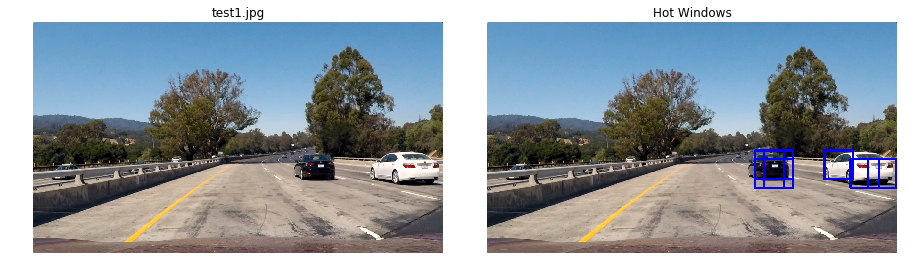

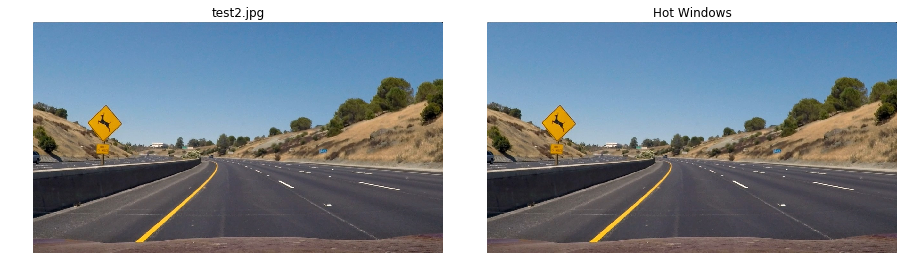

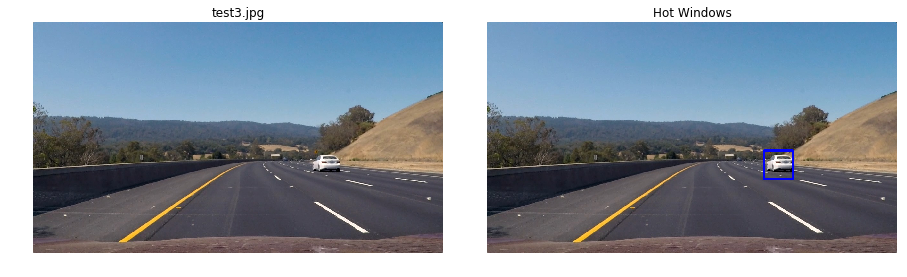

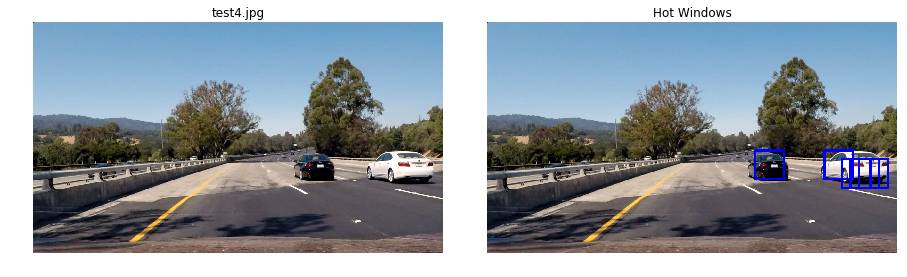

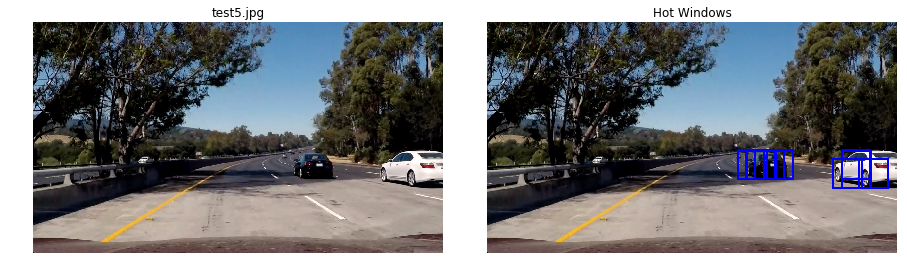

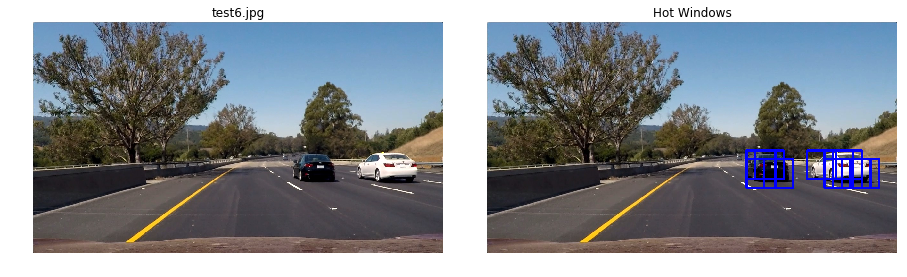

In [6]:
from ipywidgets import interact_manual, fixed
import ipywidgets as widgets

def search_window_interactor(xwin, ywin, xoverlap, yoverlap):
    for filename in os.listdir(TEST_IMAGES_DIR):
        image = cv2.imread(TEST_IMAGES_DIR + filename)

        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=(Y_BEGIN, Y_END), 
                               xy_window=(xwin, ywin), xy_overlap=(xoverlap, yoverlap))

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, spatial_size=spatial_size, 
                                     hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                     hog_channel=hog_channel)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        window_img = np.copy(image)
        draw_boxes(window_img, hot_windows, color=(0, 0, 255), thick=6)

        fig, ax = plt.subplots(1, 2, figsize=(12,8))
        fig.tight_layout()
        ax[0].imshow(image)
        ax[0].set_title(filename)
        ax[0].set_axis_off()
        ax[1].imshow(window_img)
        ax[1].set_title('Hot Windows')
        ax[1].set_axis_off()
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
        plt.show()
        
interact_manual(search_window_interactor, 
                xwin=widgets.IntSlider(min=0,max=400,step=5,value=90, description="X Window"),                
                ywin=widgets.IntSlider(min=0,max=400,step=5,value=90, description="Y Window"),                
                xoverlap=widgets.FloatSlider(min=0,max=1,step=0.1,value=0.7, description="X Overlap"),                
                yoverlap=widgets.FloatSlider(min=0,max=1,step=0.1,value=0.7, description="Y Overlap"));

## Sliding Windows Optimized
---

In [7]:
from scipy.ndimage.measurements import label

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
              cells_per_step, decision_thresh):
                                                                              
    if scale != 1:
        imshape = img.shape
        img = cv2.resize(img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            spatial_features = []
            if (spatial_size[0] > 0 and spatial_size[1] > 0):
                spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_featrues = []
            if (hist_bins > 0):
                hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            #if test_prediction == 1:
            if (svc.decision_function(test_features) > decision_thresh):
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0, 255)
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def pipeline(img, ystart, ystop, scales, svc, X_scaler, 
             orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
             cells_per_step, decision_thresh, debug=False):
    
    img_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    img_tosearch = img_tosearch[ystart:ystop,:,:]
    img_tosearch.astype(np.float32)/255
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)

    if (debug):
        window_img = np.copy(img)

    for scale in scales:
        car_windows = find_cars(img_tosearch, ystart, ystop, scale, svc, X_scaler, 
                                orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                                cells_per_step, decision_thresh)

        # Add heat to each box in box list
        heatmap = add_heat(heatmap,car_windows)
        if (debug):
            draw_boxes(window_img, car_windows, color=(0, 0, 255), thick=6)
        
    if (debug):
        return heatmap, window_img

    return heatmap

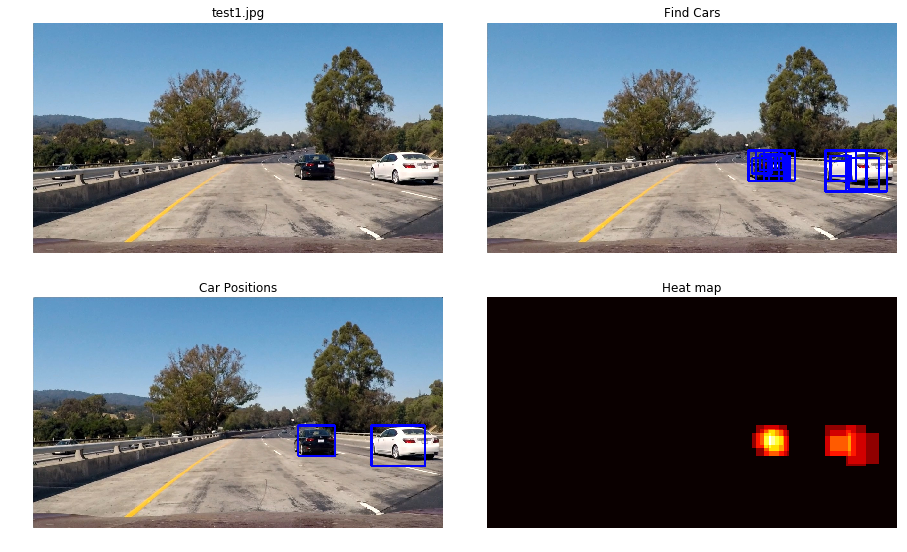

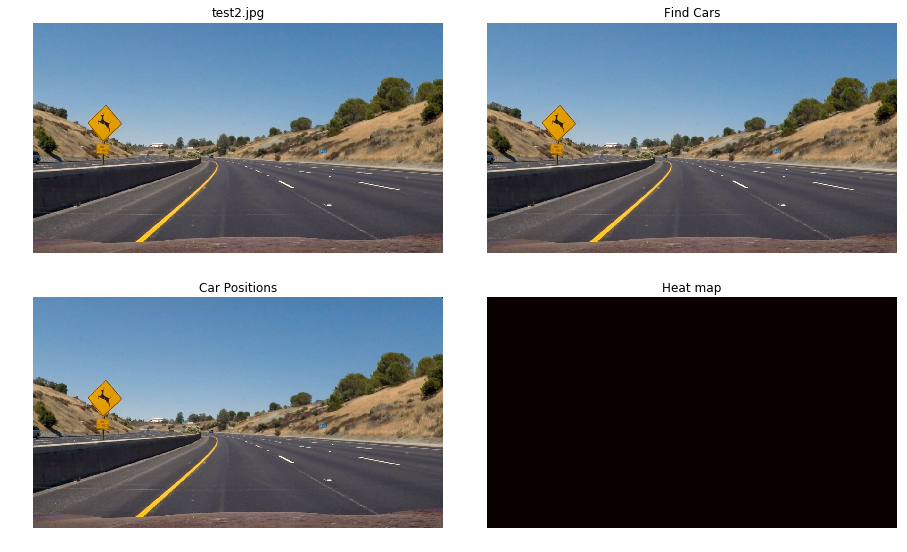

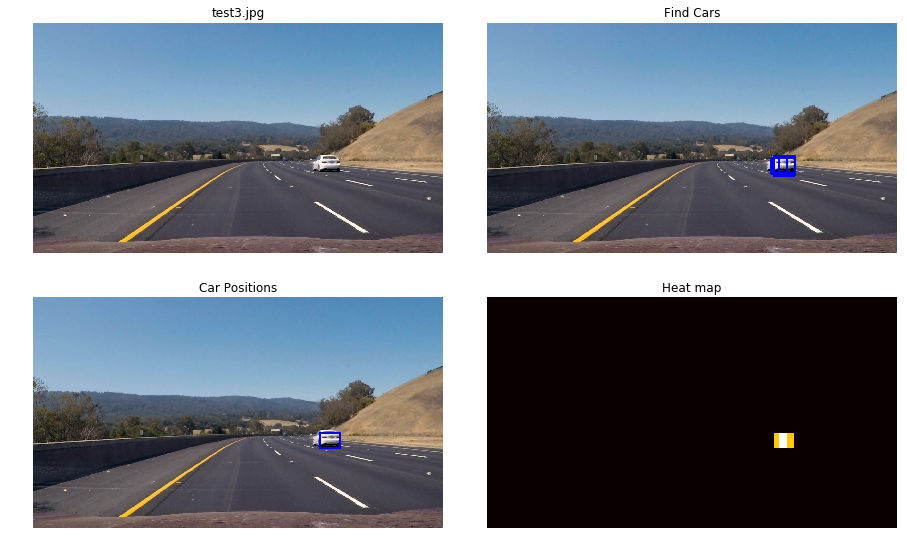

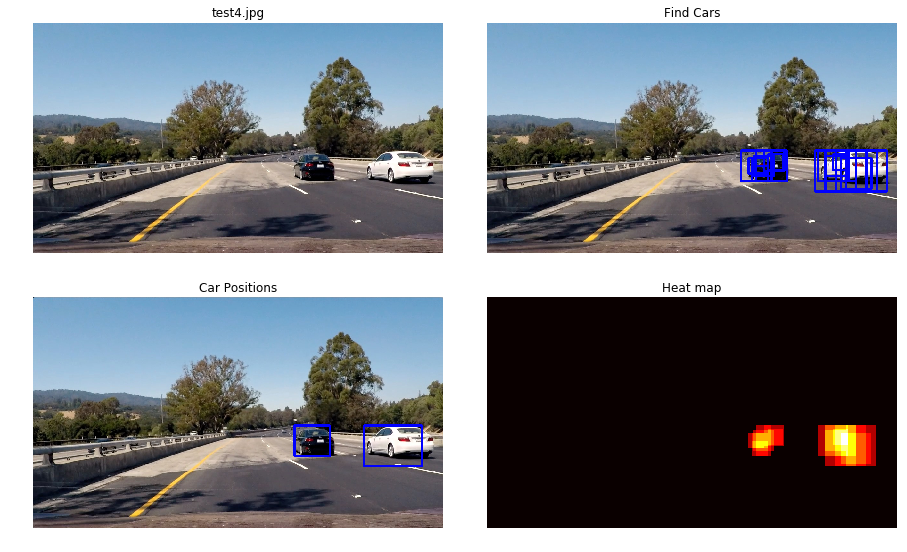

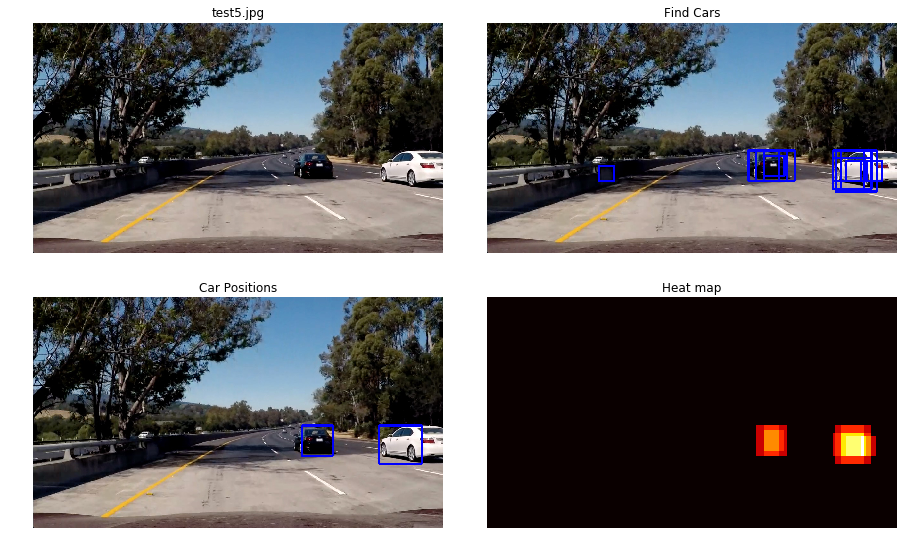

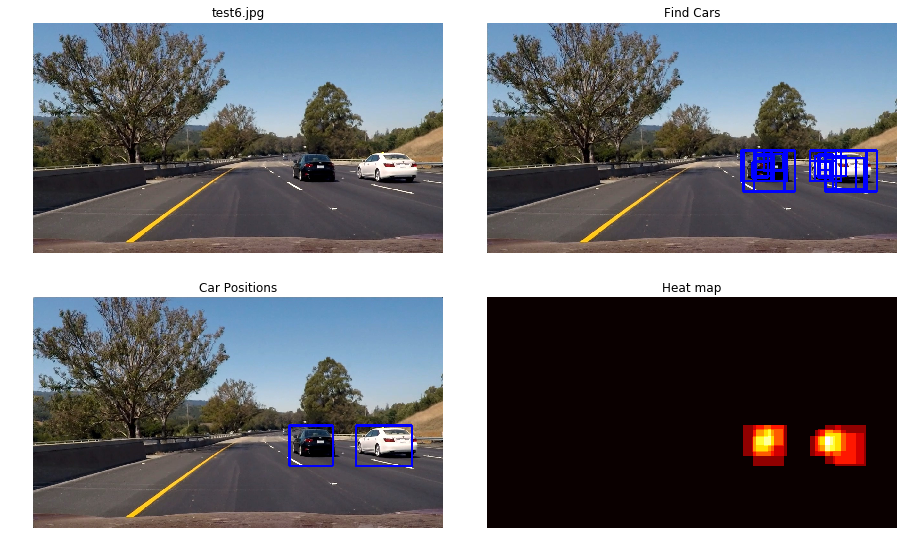

In [9]:
scales = [0.75,1.0,1.5,2,3]
heatmap_thresh = 1
cells_per_step = 2
decision_thresh = 0.8

for filename in os.listdir(TEST_IMAGES_DIR):
    image = cv2.imread(TEST_IMAGES_DIR + filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    heatmap, window_img = pipeline(image, Y_BEGIN, Y_END, scales, svc, X_scaler, 
                                   orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                                   cells_per_step, decision_thresh, debug=True)
    
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap, heatmap_thresh)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    out_img = np.copy(image)
    draw_labeled_bboxes(out_img, labels)

    fig, ax = plt.subplots(2, 2, figsize=(12,8))
    fig.tight_layout()
    ax[0][0].imshow(image)
    ax[0][0].set_title(filename)
    ax[0][0].set_axis_off()
    ax[0][1].imshow(window_img)
    ax[0][1].set_title('Find Cars')
    ax[0][1].set_axis_off()
    ax[1][0].imshow(out_img)
    ax[1][0].set_title('Car Positions')
    ax[1][0].set_axis_off()
    ax[1][1].imshow(heatmap, cmap='hot')
    ax[1][1].set_title('Heat map')
    ax[1][1].set_axis_off()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    plt.show()

## Video Implementation
---

In [10]:
# Implement a circular array to store the heatmaps of the last 10 frames
counter = 0
n_frames = 10
heatmaps = []
for i in range(n_frames):
    heatmaps.append(np.zeros((IMAGE_SHAPE[0], IMAGE_SHAPE[1])))

def process_image(image):
    global counter
    heatmap = pipeline(image, Y_BEGIN, Y_END, scales, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                       cells_per_step, decision_thresh, debug=False)
    
    heatmaps[counter % n_frames] = heatmap
    
    final_heatmap = np.zeros_like(heatmap)
    for i in range(n_frames):
        final_heatmap += heatmaps[i]
    
    # Apply threshold to help remove false positives
    final_heatmap = apply_threshold(final_heatmap, heatmap_thresh * (n_frames//2))

    # Find final boxes from heatmap using label function
    labels = label(final_heatmap)
    out_img = np.copy(image)
    draw_labeled_bboxes(out_img, labels)
  
    #mpimg.imsave("debug_images/image{:04}.jpg".format(counter), image)
    #mpimg.imsave("debug_images/heatmap{:04}.jpg".format(counter), heatmap)
    #mpimg.imsave("debug_images/finalhm{:04}.jpg".format(counter), final_heatmap)
    #mpimg.imsave("debug_images/outimg{:04}.jpg".format(counter), out_img)

    counter += 1
    return out_img

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

filenames = [
    ("project_video.mp4", "project.mp4"),
    #("test_video.mp4", "test.mp4")
]

for infile, outfile in filenames:
    clip = VideoFileClip(infile)
    clip_processed = clip.fl_image(process_image)
    %time clip_processed.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|███████████████████████████████████▉| 1260/1261 [1:25:54<00:04,  4.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

Wall time: 1h 25min 56s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{}">
</video>
""".format("project.mp4"))